# Forward simulation of uniaxial permittivity tensor imaging (uPTI) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift, fftn, ifftn

import pickle
import waveorder as wo
import time



%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Parameters of imaging system

In [3]:
N           = 200                 # number of pixel in y dimension
M           = 200                 # number of pixel in x dimension
L           = 100                 # number of layers in z dimension
n_media     = 1.518               # refractive index in the media
mag         = 63                  # magnification
ps          = 6/mag               # effective pixel size
psz         = 0.125/2             # axial pixel size
lambda_illu = 0.532               # wavelength
NA_obj      = 1.47                # objective NA
NA_illu     = 1.4                 # illumination NA
chi         = 0.25*2*np.pi        # swing of the microscope
z_defocus = (np.r_[:L]-L//2)*psz  # defocus position
use_gpu     = True                # option to use gpu
gpu_id      = 0                   # gpu to be used

## Sample :  star with uniform retardance, radial azimuth, and constant inclination

In [5]:

## generate 3D target ##
# blur_size = 1*ps
# target, azimuth, inc_angle = wo.genStarTarget_3D((N,M,L), ps, psz, blur_size, inc_upper_bound=np.pi/8, inc_range=np.pi/64)
# inc_angle = np.round(inc_angle/np.pi*8)/8*np.pi
# azimuth   = np.round(azimuth/np.pi/2*16)/16*np.pi*2


## generate 2D target ##

target, azimuth, _ = wo.genStarTarget(N,M, blur_px=1*ps, margin=60)
inc_angle = np.ones_like(target)*np.pi/3
azimuth   = azimuth%(np.pi*2)
azimuth   = np.round(azimuth/np.pi/2*16)/16*np.pi*2

target = np.pad(target[:,:,np.newaxis], ((0,0), (0,0), (50,49)), mode='constant')
azimuth = np.tile(azimuth[:,:,np.newaxis], (1,1,L))
inc_angle = np.tile(inc_angle[:,:,np.newaxis], (1,1,L))

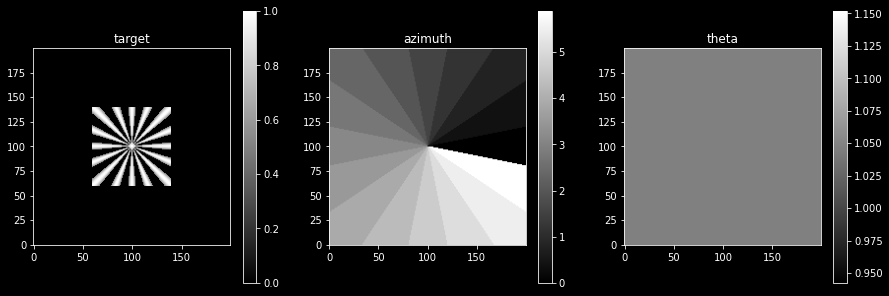

In [6]:
## xy section at z_layer ##
z_layer = 50
wo.plot_multicolumn([target[:,:,z_layer], azimuth[:,:,z_layer]%(2*np.pi), inc_angle[:,:,z_layer]], origin='lower', size=5, num_col=3, titles=['target', 'azimuth', 'theta'], set_title = True)


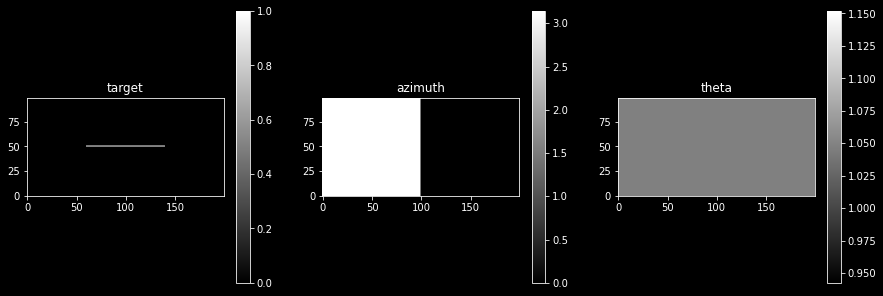

In [7]:
## xz section at y_layer ##
y_layer = 100
wo.plot_multicolumn([np.transpose(target[y_layer,:,:]), np.transpose(azimuth[y_layer,:,:])%(2*np.pi), np.transpose(inc_angle[y_layer,:,:])], origin='lower', size=5, num_col=3, titles=['target', 'azimuth', 'theta'], set_title = True)


## animate through z-slices with this function ##
# wo.parallel_4D_viewer(np.transpose(np.stack([target, azimuth%(2*np.pi), inc_angle]),(3,0,1,2)), num_col=3, size=20, origin='lower')
#################################################

In [8]:
# Assign uniform principal retardance, radial azimuth, and constant inclination to the pattern

n_o = n_media+0.01 
n_e = n_media+0.035

theta = inc_angle
orientation = (azimuth)%(2*np.pi)


no_map = np.zeros((N,M,L))
no_map[target > 0] = target[target > 0]*(n_o-n_media)
no_map += n_media
no_map_copy = no_map.copy()

ne_map = np.zeros((N,M,L))
ne_map[target > 0] = target[target > 0]*(n_e-n_media)
ne_map += n_media
ne_map_copy = ne_map.copy()


## assign material on the top to be reverse optic sign ##
# no_map[:,:,L//2:] = ne_map_copy[:,:,L//2:].copy()
# ne_map[:,:,L//2:] = no_map_copy[:,:,L//2:].copy()
#########################################################

## assign material on the right to be reverse optic sign ##
# no_map[:,M//2:,:] = ne_map_copy[:,M//2:,:].copy()
# ne_map[:,M//2:,:] = no_map_copy[:,M//2:,:].copy()
###########################################################

### assign the permittivity tensor according to the sample parameters

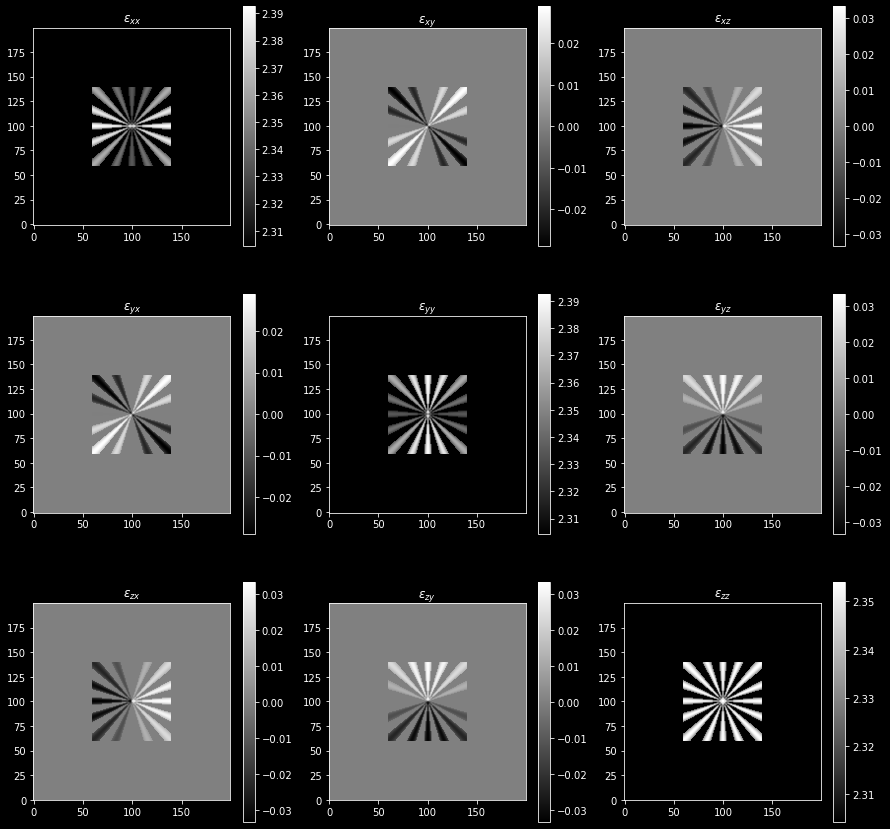

In [9]:
epsilon_mean = (ne_map**2 + no_map**2)/2
epsilon_del = (ne_map**2 - no_map**2)/2

epsilon_tensor = np.zeros((3,3,N,M,L))
epsilon_tensor[0,0] = epsilon_mean - epsilon_del*(np.cos(theta)**2 - np.sin(theta)**2 * np.cos(2*orientation))
epsilon_tensor[0,1] = epsilon_del * np.sin(theta)**2 * np.sin(2*orientation)
epsilon_tensor[0,2] = epsilon_del * np.sin(2*theta) * np.cos(orientation)

epsilon_tensor[1,0] = epsilon_del * np.sin(theta)**2 * np.sin(2*orientation)
epsilon_tensor[1,1] = epsilon_mean - epsilon_del*(np.cos(theta)**2 + np.sin(theta)**2 * np.cos(2*orientation))
epsilon_tensor[1,2] = epsilon_del * np.sin(2*theta) * np.sin(orientation)

epsilon_tensor[2,0] = epsilon_del * np.sin(2*theta) * np.cos(orientation)
epsilon_tensor[2,1] = epsilon_del * np.sin(2*theta) * np.sin(orientation)
epsilon_tensor[2,2] = epsilon_mean + epsilon_del*np.cos(2*theta)

wo.plot_multicolumn([epsilon_tensor[0,0,:,:,z_layer], epsilon_tensor[0,1,:,:,z_layer], epsilon_tensor[0,2,:,:,z_layer],\
                     epsilon_tensor[1,0,:,:,z_layer], epsilon_tensor[1,1,:,:,z_layer], epsilon_tensor[1,2,:,:,z_layer],\
                     epsilon_tensor[2,0,:,:,z_layer], epsilon_tensor[2,1,:,:,z_layer], epsilon_tensor[2,2,:,:,z_layer]], origin='lower', num_col=3, titles=[r'$\epsilon_{xx}$', r'$\epsilon_{xy}$',r'$\epsilon_{xz}$',\
                                                                                                                                                            r'$\epsilon_{yx}$', r'$\epsilon_{yy}$', r'$\epsilon_{yz}$',\
                                                                                                                                                            r'$\epsilon_{zx}$', r'$\epsilon_{zy}$', r'$\epsilon_{zz}$'],\
                                                                                                                                                            size=5, set_title = True)


In [13]:
## animate through z-slices with this function ##
# wo.parallel_4D_viewer(np.transpose(epsilon_tensor.reshape((9, N, M, L)),(3,0,1,2)), num_col=3, size=5, origin='lower')
#################################################

### Compute components of scattering potential tensor ($\nabla f$)

In [11]:
# the corresponding components of the scattering potential tensor

del_f_component = np.zeros((7, N, M, L))
del_f_component[0] = np.real(((2*np.pi/lambda_illu)**2)*(n_media**2 -  epsilon_mean + epsilon_del*np.cos(theta)**2))
del_f_component[1] = np.imag(((2*np.pi/lambda_illu)**2)*(n_media**2 -  epsilon_mean + epsilon_del*np.cos(theta)**2))
del_f_component[2] = -((2*np.pi/lambda_illu)**2) * epsilon_del * np.sin(theta)**2 * np.cos(2*orientation)
del_f_component[3] = -((2*np.pi/lambda_illu)**2) * epsilon_del * np.sin(theta)**2 * np.sin(2*orientation)
del_f_component[4] = -((2*np.pi/lambda_illu)**2) * epsilon_del * np.sin(2*theta) * np.cos(orientation)
del_f_component[5] = -((2*np.pi/lambda_illu)**2) * epsilon_del * np.sin(2*theta) * np.sin(orientation)
del_f_component[6] = ((2*np.pi/lambda_illu)**2) * epsilon_del * (np.sin(theta)**2 - 2*np.cos(theta)**2)

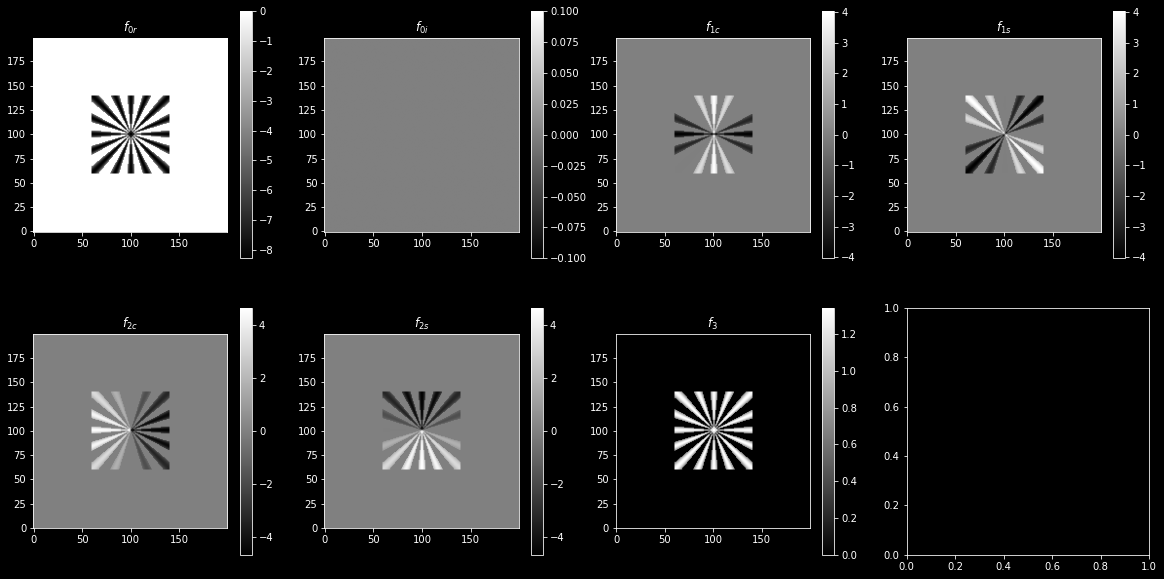

In [12]:
wo.plot_multicolumn([del_f_component[0,:,:,z_layer], del_f_component[1,:,:,z_layer], del_f_component[2,:,:,z_layer], del_f_component[3,:,:,z_layer],\
                     del_f_component[4,:,:,z_layer], del_f_component[5,:,:,z_layer], del_f_component[6,:,:,z_layer]], origin='lower', num_col=4, titles=[r'$f_{0r}$', r'$f_{0i}$', r'$f_{1c}$',r'$f_{1s}$',\
                                                                                                                                                         r'$f_{2c}$', r'$f_{2s}$', r'$f_{3}$'],\
                                                                                                                                                         size=5, set_title = True)


In [27]:
## animate through z-slices with this function ##
# wo.parallel_4D_viewer(np.transpose(del_f_component,(3,0,1,2)), num_col=4, origin='lower')
#################################################

### Rendering the principal retardance and 3D orientation in color

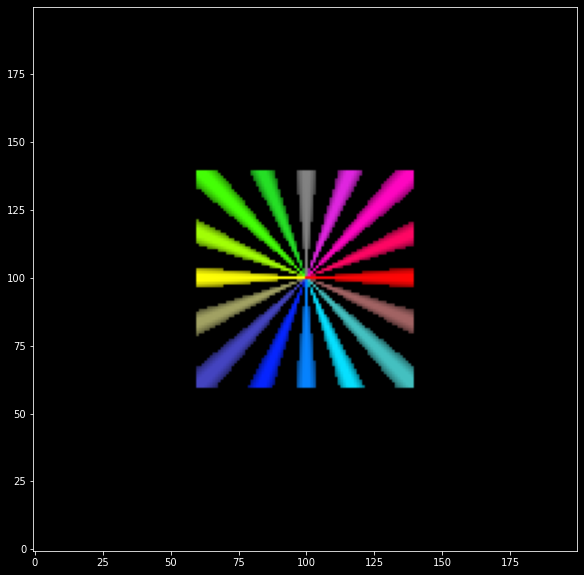

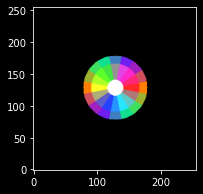

In [14]:

orientation_3D_image = np.transpose(np.array([orientation%(2*np.pi)/2/np.pi, theta,  np.clip((ne_map-no_map)*psz*2*np.pi/lambda_illu/np.pi/2*lambda_illu*1e3,0, 1.5)/1.5]),(3,1,2,0))
orientation_3D_image_RGB = wo.orientation_3D_to_rgb(orientation_3D_image, interp_belt = 20/180*np.pi, sat_factor = 1)

plt.figure(figsize=(10,10))
plt.imshow(orientation_3D_image_RGB[z_layer], origin='lower')
# wo.rgb_stack_viewer(orientation_3D_image_RGB, size=10, origin='lower')
plt.figure(figsize=(3,3))
wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1, discretize=True)

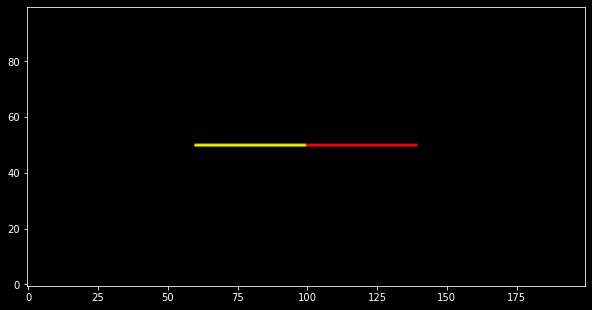

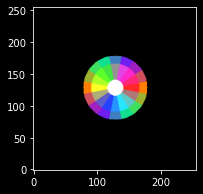

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(orientation_3D_image_RGB[:,y_layer], origin='lower')
#wo.rgb_stack_viewer(np.transpose(orientation_3D_image_RGB,(1,0,2,3)), size=10, origin='lower')
plt.figure(figsize=(3,3))
wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1,  discretize=True)

### Angular histogram of 3D orientation

(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

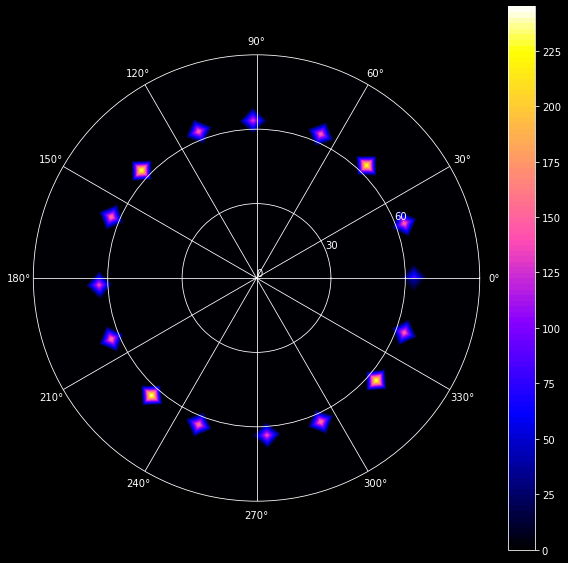

In [17]:
wo.orientation_3D_hist(azimuth.flatten(), \
                       inc_angle.flatten(), \
                       np.abs(target).flatten(),\
                       bins=36, num_col=1, size=10, contour_level = 100, hist_cmap='gnuplot2', top_hemi=True)

## Forward model of uPTI <br>(polarization-diverse, illumination-diverse, depth-diverse acquisition)

In [18]:
# DPC + BF illumination + PolState (sector illumination)

xx, yy, fxx, fyy = wo.gen_coordinate((N, M), ps)
Pupil_obj = wo.gen_Pupil(fxx, fyy, NA_obj/n_media, lambda_illu/n_media)
Source_support = wo.gen_Pupil(fxx, fyy, NA_illu/n_media, lambda_illu/n_media)

NAx_coord = lambda_illu/n_media*fxx
NAy_coord = lambda_illu/n_media*fyy


rotation_angle=[0, 45, 90, 135, 180, 225, 270, 315]


Source = np.zeros((len(rotation_angle)+1, N, M))
Source_cont = np.zeros_like(Source)

Source_BF = wo.gen_Pupil(fxx, fyy, NA_illu/n_media/2, lambda_illu/n_media)


Source_cont[-1] = Source_BF.copy()
Source[-1] = wo.Source_subsample(Source_BF, NAx_coord, NAy_coord, subsampled_NA = 0.1/n_media)



for i in range(len(rotation_angle)):
    deg = rotation_angle[i]
    Source_temp = np.zeros((N,M))
    Source_temp2 = np.zeros((N,M))
    Source_temp[fyy * np.cos(np.deg2rad(deg-22.5)) - fxx*np.sin(np.deg2rad(deg-22.5)) > 1e-10] = 1
    Source_temp2[fyy * np.cos(np.deg2rad(deg-135-22.5)) - fxx*np.sin(np.deg2rad(deg-135-22.5)) > 1e-10] = 1
    
    Source_cont[i] = Source_temp * Source_temp2 * Source_support 
    
    Source_discrete = wo.Source_subsample(Source_cont[i], NAx_coord, NAy_coord, subsampled_NA = 0.1/n_media)
    Source[i] = np.maximum(0,Source_discrete.copy())
    
    

Source_PolState = np.zeros((len(Source),2), complex)

for i in range(len(Source)):
    Source_PolState[i,0] = 1
    Source_PolState[i,1] = 1j


#### Circularly polarized illumination patterns

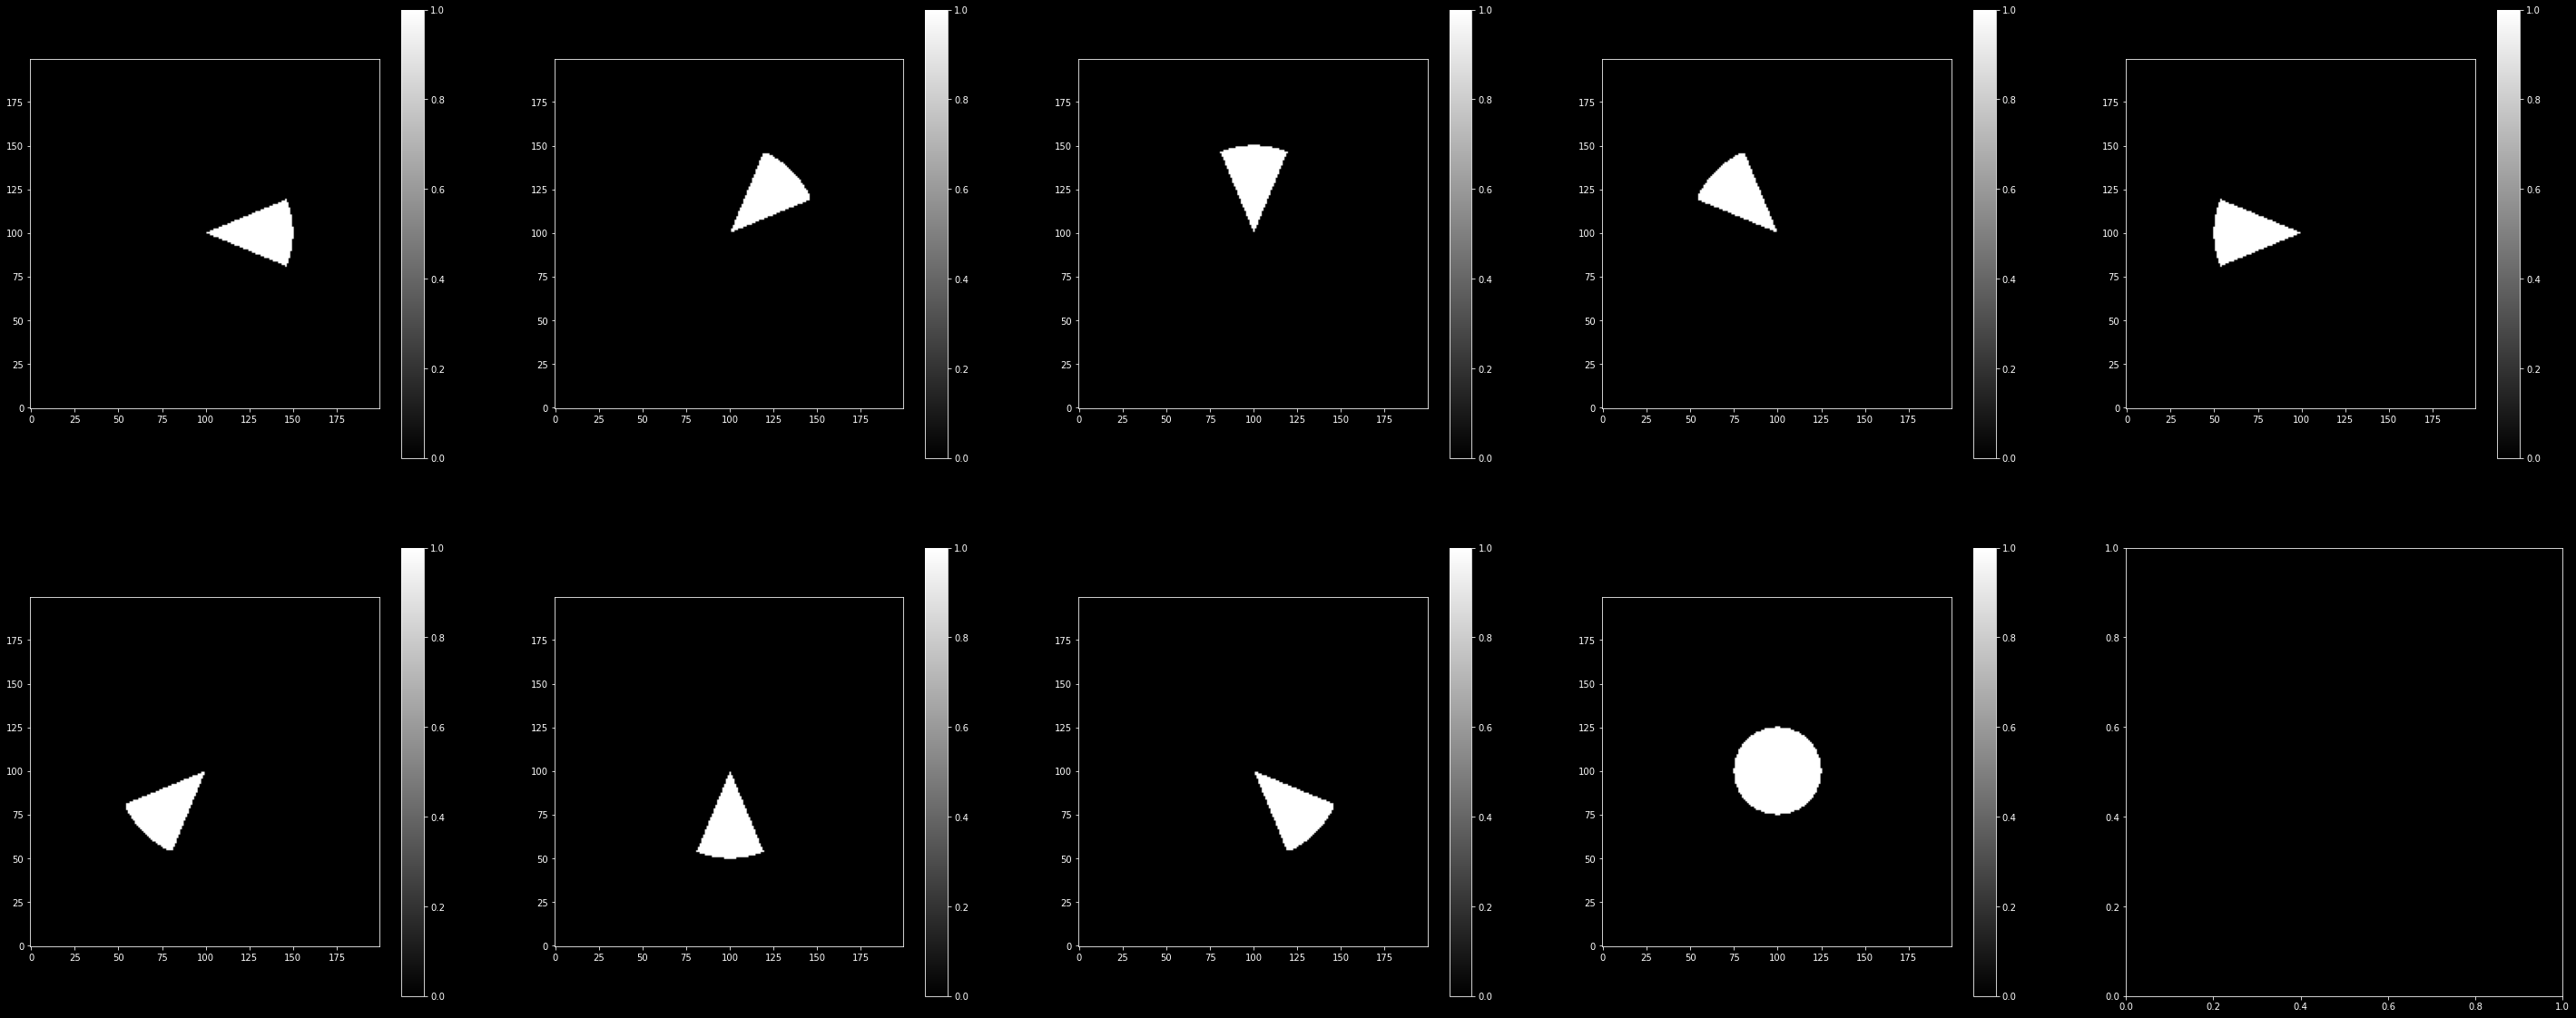

In [19]:
wo.plot_multicolumn(fftshift(Source_cont,axes=(1,2)), origin='lower', num_col=5)

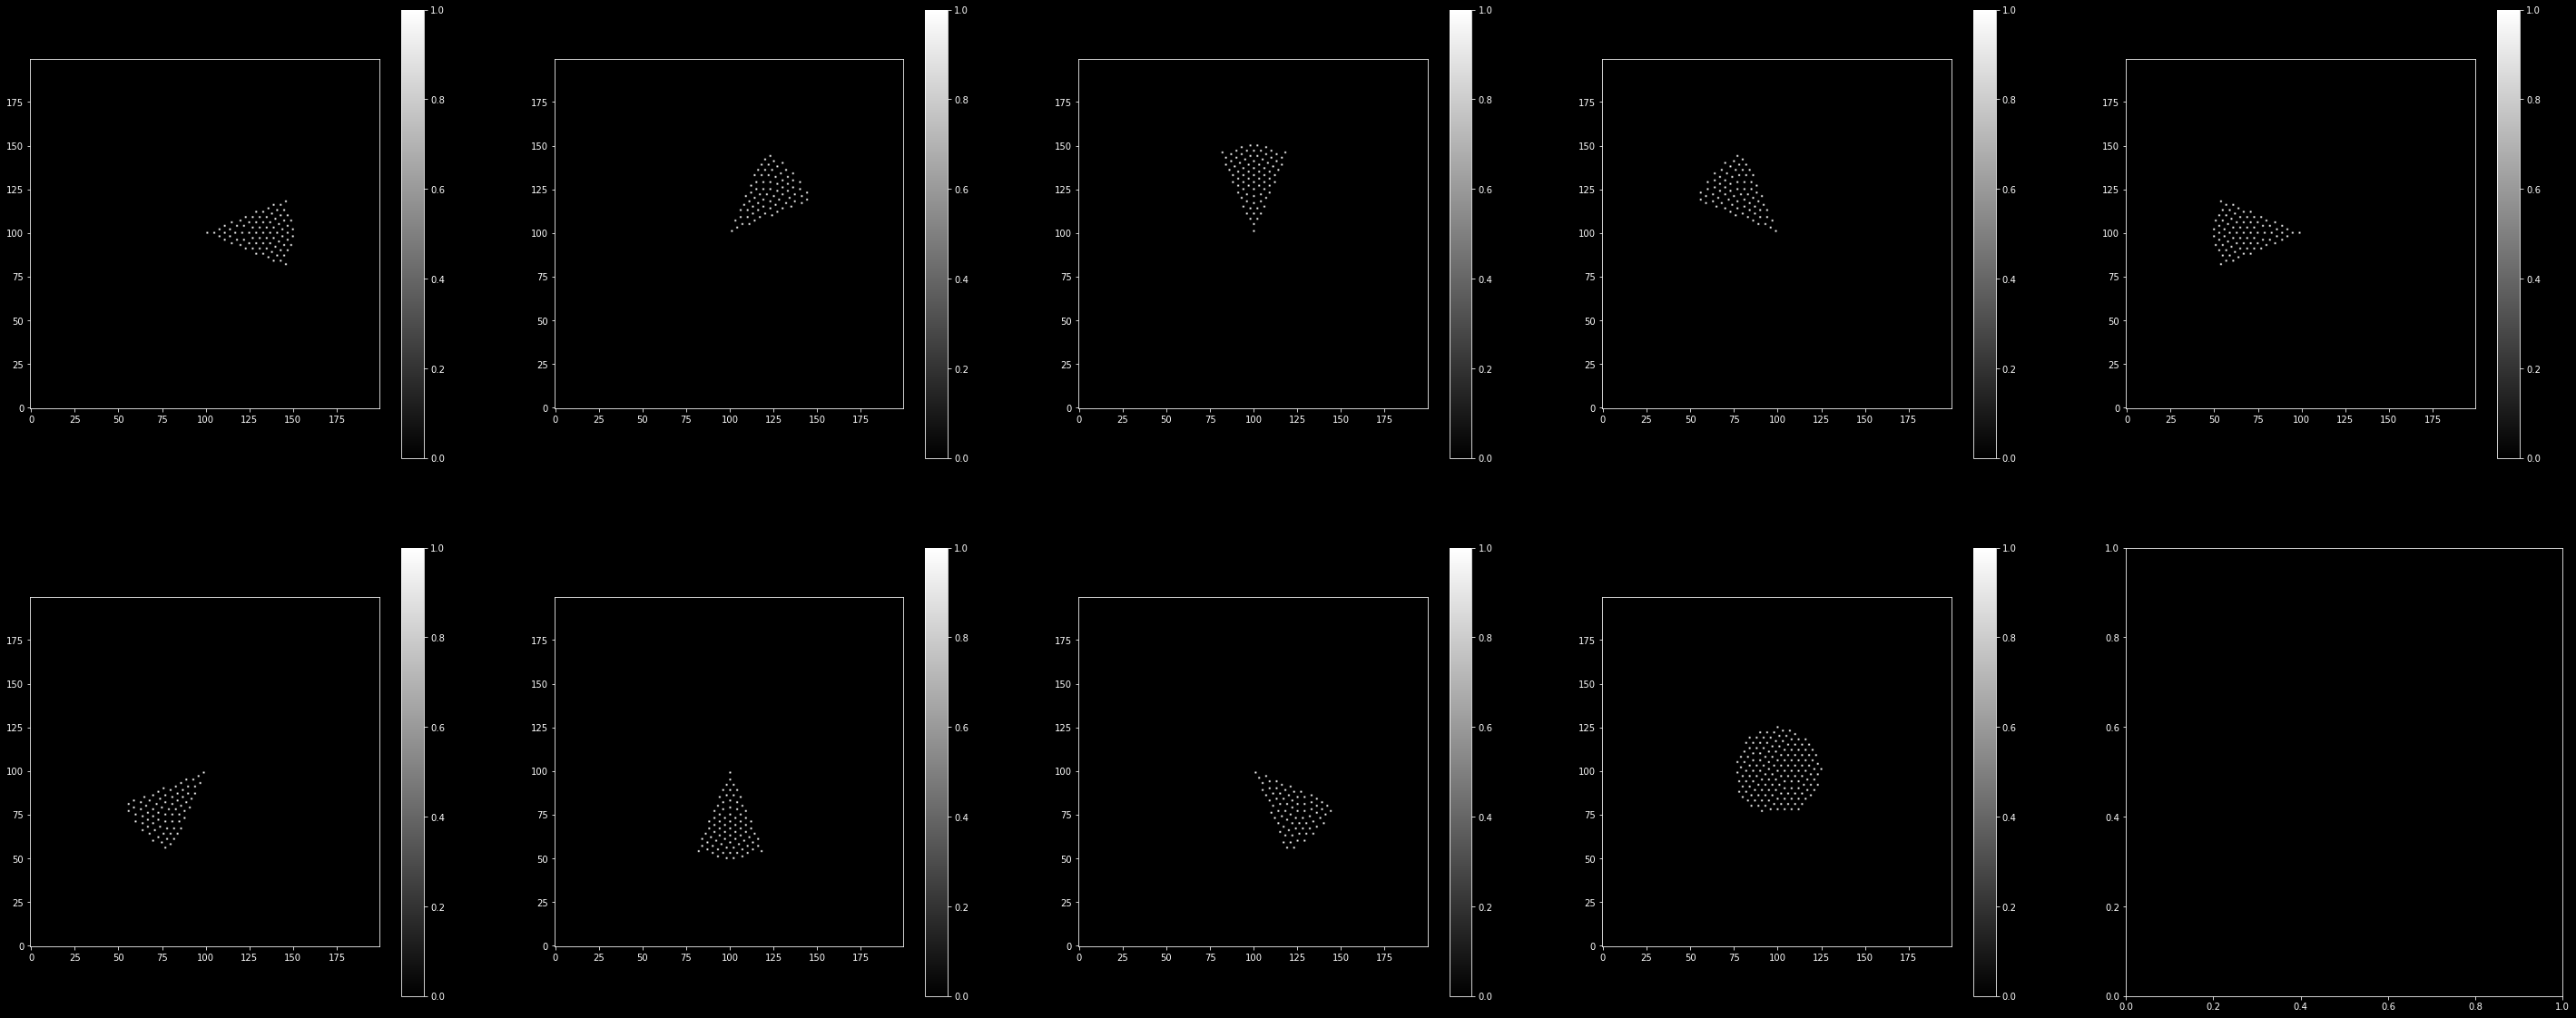

In [20]:
# discretized illumination patterns used in simulation (faster forward model)
wo.plot_multicolumn(fftshift(Source,axes=(1,2)), origin='lower', num_col=5, size=10)

In [21]:
Source_PolState

array([[1.+0.j, 0.+1.j],
       [1.+0.j, 0.+1.j],
       [1.+0.j, 0.+1.j],
       [1.+0.j, 0.+1.j],
       [1.+0.j, 0.+1.j],
       [1.+0.j, 0.+1.j],
       [1.+0.j, 0.+1.j],
       [1.+0.j, 0.+1.j],
       [1.+0.j, 0.+1.j]])

array([ 85.,  78.,  85.,  78.,  85.,  78.,  85.,  78., 160.])

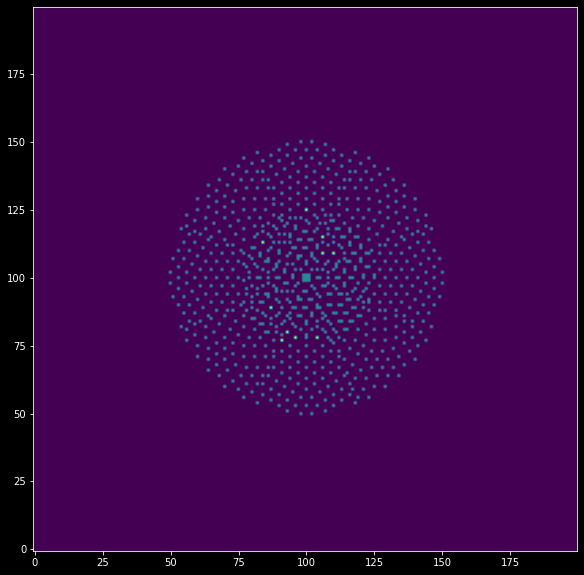

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(fftshift(np.sum(Source,axis=0)), origin='lower')
np.sum(Source,axis=(1,2))

#### Initialize microscope simulator with above source pattern and uniform imaging pupil

In [24]:
## initiate the simulator
simulator = wo.waveorder_microscopy_simulator((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media = n_media, illu_mode = 'Arbitrary', Source=Source, Source_PolState=Source_PolState, use_gpu=use_gpu, gpu_id=gpu_id)


In [25]:
## If we want to plot transfer functions, we need to initialize the solver ## 

setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media = n_media, inc_recon='3D', phase_deconv='3D', illu_mode = 'Arbitrary', \
                                Source=Source_cont, Source_PolState=Source_PolState, use_gpu=use_gpu, gpu_id=gpu_id)

## clean up gpu space
import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()


z_idx = L//2
plot_list = []
plot_list_xz = []
for i in range(4):
    for j in range(7):
        OTF_fftshift = fftshift(setup.H_dyadic_OTF[i,j],axes=(1,2,3))
        
        plot_list.append(np.real(OTF_fftshift[:,:,:,z_idx]))
        plot_list.append(np.imag(OTF_fftshift[:,:,:,z_idx]))
        plot_list_xz.append(np.real(OTF_fftshift[:,N//2,:,:]))
        plot_list_xz.append(np.imag(OTF_fftshift[:,N//2,:,:]))
        
        
z_idx = L//2
plot_list_abs = []
plot_list_xz_abs = []
for i in range(4):
    for j in range(7):
        OTF_fftshift = fftshift(setup.H_dyadic_OTF[i,j],axes=(1,2,3))
        
        plot_list_abs.append(np.abs(OTF_fftshift[:,:,:,z_idx]))
        plot_list_xz_abs.append(np.abs(OTF_fftshift[:,N//2,:,:]))

normalization_energy = np.max(np.sum(np.abs(np.transpose(np.real(np.stack(plot_list_abs)), (1,0,2,3))),axis=0),axis=(1,2))[1]

#### Visualize the sum of transfer functions over all patterns

In [26]:
# xy section of the sum of transfer functions over all patterns
wo.parallel_4D_viewer(np.sum(np.abs(np.transpose(np.real(np.stack(plot_list_abs)), (1,0,2,3)))/normalization_energy,axis=0)[np.newaxis,...], num_col=7, size=8, colormap='jet', origin='lower', vrange=[0, 0.2])

interactive(children=(IntSlider(value=0, description='stack_idx', max=0), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [27]:
# xz section of the sum of transfer functions over all patterns
wo.parallel_4D_viewer(np.sum(np.abs(np.transpose(np.real(np.stack(plot_list_xz_abs)), (1,0,3,2)))/normalization_energy,axis=0)[np.newaxis,...], num_col=7, size=8, colormap='jet', origin='lower', vrange=[0, 0.2])

interactive(children=(IntSlider(value=0, description='stack_idx', max=0), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [28]:
# animate xy section of transfer functions through different illumination patterns
wo.parallel_4D_viewer(np.transpose(np.real(np.stack(plot_list))/normalization_energy, (1,0,2,3)), num_col=14, size=5, colormap='jet', origin='lower', vrange=[-0.01, 0.01])

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [29]:
# animate xz section of transfer functions through different illumination patterns
wo.parallel_4D_viewer(np.transpose(np.real(np.stack(plot_list_xz))/normalization_energy, (1,0,3,2)), num_col=14, size=5, colormap='jet', origin='lower', vrange=[-0.01, 0.01])

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

## Compute image volumes and Stokes volumes with vectorial simulation

In [30]:
# forward simulation done by vectorial SEAGLE implementation 
# (when itr_max = 0, we use the first Born approximation)

I_meas_SEAGLE, Stokes_SEAGLE = simulator.simulate_3D_vectorial_measurements_SEAGLE(epsilon_tensor, itr_max = 0, tolerance=1e-4, verbose=False)

Number of point sources considered (1 / 85) in pattern (1 / 9), elapsed time: 4.09
Number of point sources considered (2 / 85) in pattern (1 / 9), elapsed time: 4.92
Number of point sources considered (3 / 85) in pattern (1 / 9), elapsed time: 5.70
Number of point sources considered (4 / 85) in pattern (1 / 9), elapsed time: 6.48
Number of point sources considered (5 / 85) in pattern (1 / 9), elapsed time: 7.25
Number of point sources considered (6 / 85) in pattern (1 / 9), elapsed time: 8.05
Number of point sources considered (7 / 85) in pattern (1 / 9), elapsed time: 8.82
Number of point sources considered (8 / 85) in pattern (1 / 9), elapsed time: 9.60
Number of point sources considered (9 / 85) in pattern (1 / 9), elapsed time: 10.38
Number of point sources considered (10 / 85) in pattern (1 / 9), elapsed time: 11.16
Number of point sources considered (11 / 85) in pattern (1 / 9), elapsed time: 11.94
Number of point sources considered (12 / 85) in pattern (1 / 9), elapsed time: 12.

Number of point sources considered (13 / 78) in pattern (2 / 9), elapsed time: 79.99
Number of point sources considered (14 / 78) in pattern (2 / 9), elapsed time: 80.77
Number of point sources considered (15 / 78) in pattern (2 / 9), elapsed time: 81.55
Number of point sources considered (16 / 78) in pattern (2 / 9), elapsed time: 82.33
Number of point sources considered (17 / 78) in pattern (2 / 9), elapsed time: 83.11
Number of point sources considered (18 / 78) in pattern (2 / 9), elapsed time: 83.90
Number of point sources considered (19 / 78) in pattern (2 / 9), elapsed time: 84.68
Number of point sources considered (20 / 78) in pattern (2 / 9), elapsed time: 85.46
Number of point sources considered (21 / 78) in pattern (2 / 9), elapsed time: 86.25
Number of point sources considered (22 / 78) in pattern (2 / 9), elapsed time: 87.03
Number of point sources considered (23 / 78) in pattern (2 / 9), elapsed time: 87.82
Number of point sources considered (24 / 78) in pattern (2 / 9), 

Number of point sources considered (31 / 85) in pattern (3 / 9), elapsed time: 155.30
Number of point sources considered (32 / 85) in pattern (3 / 9), elapsed time: 156.08
Number of point sources considered (33 / 85) in pattern (3 / 9), elapsed time: 156.86
Number of point sources considered (34 / 85) in pattern (3 / 9), elapsed time: 157.65
Number of point sources considered (35 / 85) in pattern (3 / 9), elapsed time: 158.43
Number of point sources considered (36 / 85) in pattern (3 / 9), elapsed time: 159.22
Number of point sources considered (37 / 85) in pattern (3 / 9), elapsed time: 160.00
Number of point sources considered (38 / 85) in pattern (3 / 9), elapsed time: 160.78
Number of point sources considered (39 / 85) in pattern (3 / 9), elapsed time: 161.57
Number of point sources considered (40 / 85) in pattern (3 / 9), elapsed time: 162.35
Number of point sources considered (41 / 85) in pattern (3 / 9), elapsed time: 163.13
Number of point sources considered (42 / 85) in patter

Number of point sources considered (42 / 78) in pattern (4 / 9), elapsed time: 230.58
Number of point sources considered (43 / 78) in pattern (4 / 9), elapsed time: 231.37
Number of point sources considered (44 / 78) in pattern (4 / 9), elapsed time: 232.15
Number of point sources considered (45 / 78) in pattern (4 / 9), elapsed time: 232.93
Number of point sources considered (46 / 78) in pattern (4 / 9), elapsed time: 233.72
Number of point sources considered (47 / 78) in pattern (4 / 9), elapsed time: 234.50
Number of point sources considered (48 / 78) in pattern (4 / 9), elapsed time: 235.29
Number of point sources considered (49 / 78) in pattern (4 / 9), elapsed time: 236.07
Number of point sources considered (50 / 78) in pattern (4 / 9), elapsed time: 236.86
Number of point sources considered (51 / 78) in pattern (4 / 9), elapsed time: 237.64
Number of point sources considered (52 / 78) in pattern (4 / 9), elapsed time: 238.42
Number of point sources considered (53 / 78) in patter

Number of point sources considered (60 / 85) in pattern (5 / 9), elapsed time: 305.94
Number of point sources considered (61 / 85) in pattern (5 / 9), elapsed time: 306.72
Number of point sources considered (62 / 85) in pattern (5 / 9), elapsed time: 307.50
Number of point sources considered (63 / 85) in pattern (5 / 9), elapsed time: 308.29
Number of point sources considered (64 / 85) in pattern (5 / 9), elapsed time: 309.07
Number of point sources considered (65 / 85) in pattern (5 / 9), elapsed time: 309.86
Number of point sources considered (66 / 85) in pattern (5 / 9), elapsed time: 310.64
Number of point sources considered (67 / 85) in pattern (5 / 9), elapsed time: 311.43
Number of point sources considered (68 / 85) in pattern (5 / 9), elapsed time: 312.21
Number of point sources considered (69 / 85) in pattern (5 / 9), elapsed time: 312.99
Number of point sources considered (70 / 85) in pattern (5 / 9), elapsed time: 313.78
Number of point sources considered (71 / 85) in patter

Number of point sources considered (71 / 78) in pattern (6 / 9), elapsed time: 381.25
Number of point sources considered (72 / 78) in pattern (6 / 9), elapsed time: 382.04
Number of point sources considered (73 / 78) in pattern (6 / 9), elapsed time: 382.82
Number of point sources considered (74 / 78) in pattern (6 / 9), elapsed time: 383.60
Number of point sources considered (75 / 78) in pattern (6 / 9), elapsed time: 384.39
Number of point sources considered (76 / 78) in pattern (6 / 9), elapsed time: 385.17
Number of point sources considered (77 / 78) in pattern (6 / 9), elapsed time: 385.96
Number of point sources considered (78 / 78) in pattern (6 / 9), elapsed time: 386.74
Number of point sources considered (1 / 85) in pattern (7 / 9), elapsed time: 387.58
Number of point sources considered (2 / 85) in pattern (7 / 9), elapsed time: 388.37
Number of point sources considered (3 / 85) in pattern (7 / 9), elapsed time: 389.15
Number of point sources considered (4 / 85) in pattern (7

Number of point sources considered (4 / 78) in pattern (8 / 9), elapsed time: 456.66
Number of point sources considered (5 / 78) in pattern (8 / 9), elapsed time: 457.45
Number of point sources considered (6 / 78) in pattern (8 / 9), elapsed time: 458.23
Number of point sources considered (7 / 78) in pattern (8 / 9), elapsed time: 459.02
Number of point sources considered (8 / 78) in pattern (8 / 9), elapsed time: 459.80
Number of point sources considered (9 / 78) in pattern (8 / 9), elapsed time: 460.59
Number of point sources considered (10 / 78) in pattern (8 / 9), elapsed time: 461.37
Number of point sources considered (11 / 78) in pattern (8 / 9), elapsed time: 462.15
Number of point sources considered (12 / 78) in pattern (8 / 9), elapsed time: 462.94
Number of point sources considered (13 / 78) in pattern (8 / 9), elapsed time: 463.72
Number of point sources considered (14 / 78) in pattern (8 / 9), elapsed time: 464.51
Number of point sources considered (15 / 78) in pattern (8 /

Number of point sources considered (22 / 160) in pattern (9 / 9), elapsed time: 532.05
Number of point sources considered (23 / 160) in pattern (9 / 9), elapsed time: 532.84
Number of point sources considered (24 / 160) in pattern (9 / 9), elapsed time: 533.62
Number of point sources considered (25 / 160) in pattern (9 / 9), elapsed time: 534.41
Number of point sources considered (26 / 160) in pattern (9 / 9), elapsed time: 535.20
Number of point sources considered (27 / 160) in pattern (9 / 9), elapsed time: 535.98
Number of point sources considered (28 / 160) in pattern (9 / 9), elapsed time: 536.77
Number of point sources considered (29 / 160) in pattern (9 / 9), elapsed time: 537.56
Number of point sources considered (30 / 160) in pattern (9 / 9), elapsed time: 538.34
Number of point sources considered (31 / 160) in pattern (9 / 9), elapsed time: 539.13
Number of point sources considered (32 / 160) in pattern (9 / 9), elapsed time: 539.91
Number of point sources considered (33 / 16

Number of point sources considered (116 / 160) in pattern (9 / 9), elapsed time: 605.96
Number of point sources considered (117 / 160) in pattern (9 / 9), elapsed time: 606.75
Number of point sources considered (118 / 160) in pattern (9 / 9), elapsed time: 607.53
Number of point sources considered (119 / 160) in pattern (9 / 9), elapsed time: 608.32
Number of point sources considered (120 / 160) in pattern (9 / 9), elapsed time: 609.10
Number of point sources considered (121 / 160) in pattern (9 / 9), elapsed time: 609.89
Number of point sources considered (122 / 160) in pattern (9 / 9), elapsed time: 610.67
Number of point sources considered (123 / 160) in pattern (9 / 9), elapsed time: 611.46
Number of point sources considered (124 / 160) in pattern (9 / 9), elapsed time: 612.24
Number of point sources considered (125 / 160) in pattern (9 / 9), elapsed time: 613.03
Number of point sources considered (126 / 160) in pattern (9 / 9), elapsed time: 613.82
Number of point sources consider

In [31]:
# animate through the simulated Stokes parameters
wo.parallel_5D_viewer(np.transpose(Stokes_SEAGLE,(4,1,0,2,3)), num_col=4, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [32]:
# animate through the simulated measured intensity
wo.parallel_5D_viewer(np.transpose(I_meas_SEAGLE,(4,1,0,2,3)), num_col=5, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [33]:
## situation with no noise ##
photon_count = 5000
I_meas_noise = I_meas_SEAGLE/np.mean(I_meas_SEAGLE) * photon_count
#############################


## Add noise to the measurement ##
# photon_count = 10000
# ext_ratio    = 100
# const_bg     = photon_count/(0.5*(1-np.cos(chi)))/ext_ratio
# I_meas_noise = (np.random.poisson(I_meas_SEAGLE/np.mean(I_meas_SEAGLE) * photon_count + const_bg)).astype('float64')
##################################

In [34]:
# animate through the simulated measured intensity
wo.parallel_5D_viewer(np.transpose(I_meas_noise,(4,1,0,2,3)), num_col=5, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

#### Save simulation 

In [35]:
# Save simulations

# 3D data
# output_file = 'uPTI_simulation_data_NA_det_147_NA_illu_140_3D_spoke_discrete_no_1528_ne_1553_no_noise_Born'

# 2D data
output_file = 'uPTI_simulation_data_NA_det_147_NA_illu_140_2D_spoke_discrete_no_1528_ne_1553_no_noise_Born'

np.savez(output_file, I_meas=I_meas_noise, lambda_illu=lambda_illu, n_media=n_media, NA_obj=NA_obj, NA_illu=NA_illu,\
                      ps=ps, psz=psz, Source_cont=Source_cont, Source_PolState=Source_PolState, \
                      z_defocus=z_defocus, chi=chi)


In [36]:
import cupy as cp
import gc
gc.collect()
cp.get_default_memory_pool().free_all_blocks()